<a href="https://colab.research.google.com/github/AnjayGoel/Notebooks/blob/main/market_microstructure_time_series_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import warnings
from itertools import product
import datetime
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_returns(prices,interval_days):
  prices = prices[::interval_days]
  return (prices/prices.shift(1) - 1)

In [ ]:
days_back = int(30.5*(16)*5/7)
days_interval = 1

In [ ]:
df=pd.read_csv('./drive/MyDrive/datasets/nflx.csv')
#df = df[df.index > len(df)/2]
#df.set_index("Date",inplace=True,drop=True)
df["returns"] = get_returns(df["Close"],1)
close = np.array(df["Close"])#[-days_back:]
returns = np.array(get_returns(df["Close"],days_interval))[1:]
df.tail()

,Date,Close,returns
2801,19/02/2021,540.22,-0.014593
2802,22/02/2021,533.78,-0.011921
2803,23/02/2021,546.15,0.023174
2804,24/02/2021,553.41,0.013293
2805,25/02/2021,546.70,-0.012125


In [47]:
print(close[:11])
print(returns[:11])

[7.64 7.36 7.62 7.49 7.61 7.6  7.48 7.71 7.28 7.28 7.31]
[-0.03664921  0.03532609 -0.01706037  0.01602136 -0.00131406 -0.01578947
  0.03074866 -0.05577173  0.          0.00412088  0.00136799]


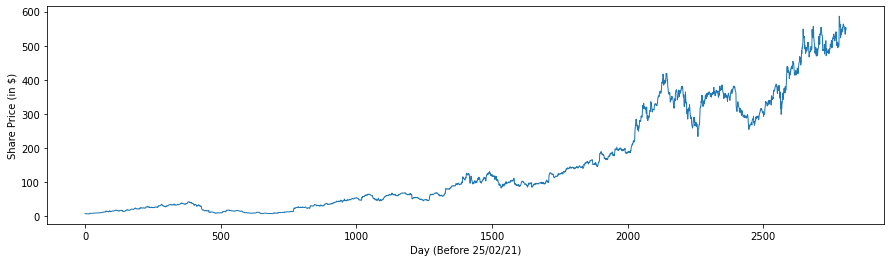

In [ ]:
plt.figure().set_figwidth(15) 
plt.xlabel('Day (Before 25/02/21)') 
plt.ylabel('Share Price (in $)') 
plt.plot(close,linewidth=1)
plt.savefig('prices.png', bbox_inches='tight',dpi=300)
plt.show()

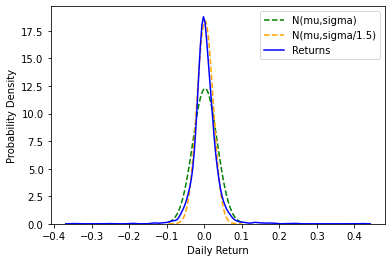

In [46]:
mu = np.mean(returns)
sigma = np.std(returns)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),ls="--",color="green",label=f"N(mu,sigma)")
plt.plot(x, stats.norm.pdf(x, mu, sigma/1.5),ls="--",color="orange",label="N(mu,sigma/1.5)")

sns.kdeplot(returns,label="Returns",color="blue")

plt.xlabel('Daily Return') 
plt.ylabel('Probability Density') 
plt.legend()
plt.savefig('return_distribution.png', bbox_inches='tight',dpi=300)
plt.show()

# Returns are approximately normally distributed.

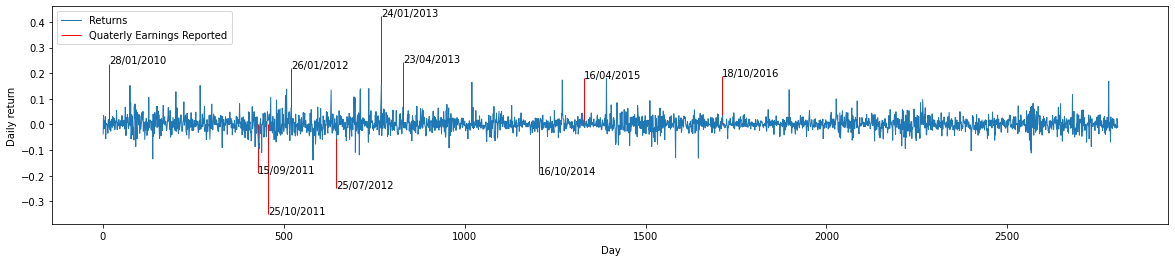

In [ ]:
lim = 0.181
plt.figure().set_figwidth(20) 
plt.xlabel('Day') 
plt.ylabel('Daily return') 
plt.plot(df[df["returns"].abs()<=lim]["returns"],linewidth=1,label ="Returns")
plt.vlines(df[df["returns"].abs()>lim].index,ymin=0,ymax=df[df["returns"].abs()>lim].returns,linewidth=1,color="red",label="Quaterly Earnings Reported")
plt.legend(loc="upper left")
for i,row in df[df["returns"].abs()>lim].iterrows():
  #plt.vlines(x=i,ymax=row["returns"],ymin=0.0,linewidth=2.0,color="red",label = "label")
  plt.annotate(row.Date, (i, row.returns))
  #print(i,row["returns"],row["Date"])
  pass
plt.savefig('returns_time_series.png', bbox_inches='tight',dpi=300)
plt.show()
# All lines in red correspond to days after the release of quaterly financial statements. (Checked Manually)

In [ ]:
print(stats.describe(returns))

DescribeResult(nobs=2805, minmax=(-0.34923439340400464, 0.4223728813559322), mean=0.0020472786114647547, variance=0.0010567685648964365, skewness=0.8895555127418517, kurtosis=22.355265011808978)


In [31]:
df.describe()

,Close,returns
count,2806.000000,2805.000000
mean,151.052384,0.002047
std,152.760215,0.032508
min,7.020000,-0.349234
25%,30.410000,-0.012536
50%,91.105000,0.000327
75%,284.777500,0.016330
max,586.340000,0.422373


In [ ]:
print(f"Mean Returns: {np.mean(returns)}")
print(f"Standrard Deviation: {np.std(returns)}")
print(f"JB Test: {stats.jarque_bera(returns)[1]}")
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(returns)[1])

Mean Returns: 0.0020472786114647547
Standrard Deviation: 0.03250218177769026
JB Test: 0.0
Dickey–Fuller test:: p=0.000000


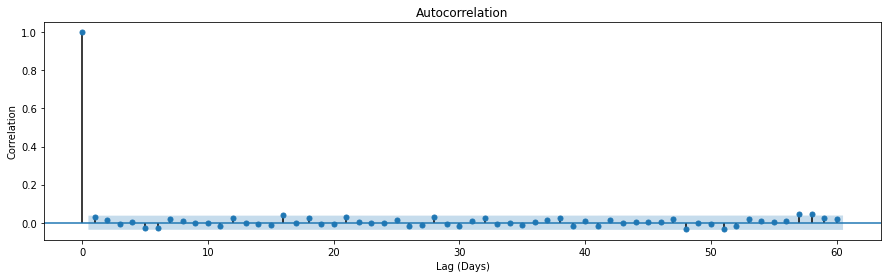

In [33]:
#acf
fig = sm.graphics.tsa.plot_acf(returns, lags=60)
fig.set_figwidth(15)
plt.xlabel('Lag (Days)') 
plt.ylabel('Correlation') 
plt.savefig('acf.png', bbox_inches='tight',dpi=300)
plt.show()

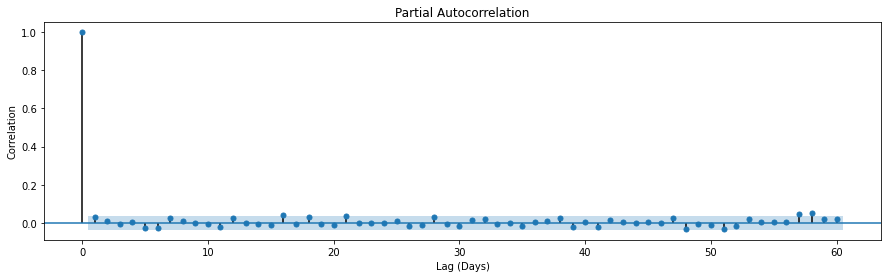

In [34]:
#pacf
fig = sm.graphics.tsa.plot_pacf(returns, lags=60)
fig.set_figwidth(15)
plt.xlabel('Lag (Days)') 
plt.ylabel('Correlation') 
plt.savefig('pacf.png', bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
# Initial approximation of parameters
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_bic = float("inf")
warnings.filterwarnings('ignore')
best_params = None
for param in parameters_list:
    try:
        model=sm.tsa.ARIMA(returns, order=(param[0], param[1], param[2])).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    bic = model.bic
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.aic])

In [ ]:
print(f"Best Fit: {best_param}")
print(best_model.summary())

Best Fit: (0, 0, 0)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2805
Model:                     ARMA(0, 0)   Log Likelihood                5631.064
Method:                           css   S.D. of innovations              0.033
Date:                Sun, 28 Feb 2021   AIC                         -11258.128
Time:                        06:57:10   BIC                         -11246.250
Sample:                             0   HQIC                        -11253.841
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.336      0.001       0.001       0.003


Best Fit Curve Turns out to be ARIMA(0,0,0) with a consant term of 0.002 & white noise with std dev of 0.033.

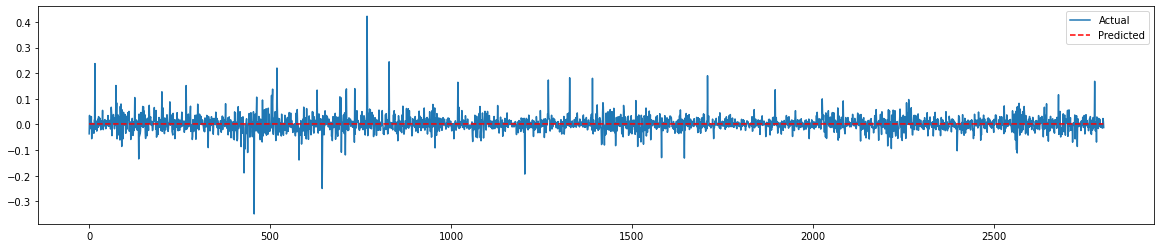

In [24]:
pred=best_model.predict(start=3, end=len(close)).squeeze()
plt.figure().set_figwidth(20) 
plt.plot(returns,label="Actual")
plt.plot(pred,color='r', ls='--', label='Predicted')
plt.savefig('predictions.png', bbox_inches='tight',dpi=300)
plt.legend()
plt.show()

Dickey–Fuller test:: p=0.000000


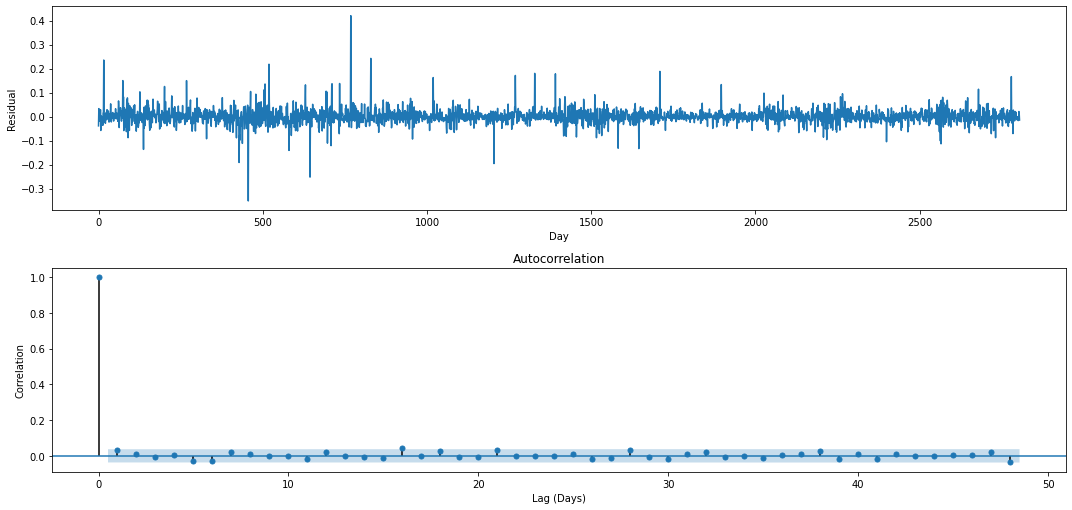

In [36]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(best_model.resid.squeeze()) #residuals
plt.xlabel('Day') 
plt.ylabel('Residual') 
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
plt.tight_layout()
plt.xlabel('Lag (Days)') 
plt.ylabel('Correlation') 
plt.savefig('prediction residuals.png', bbox_inches='tight',dpi=300)
plt.show()
